<a href="https://colab.research.google.com/github/cjssla1/projectJucker/blob/master/Code/%EA%B9%80%EA%B2%BD%EC%A4%91/regPractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
#파이토치 인스톨
!pip install -q torch==1.4.0 torchvision
import torch
print(torch.__version__)

1.4.0


In [62]:
%matplotlib inline
#데이터 생성과 화면 표시를 위한 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

#실험결과 비교를 위해 시드 고정
seed = 444
np.random.seed(seed)
torch.manual_seed(seed)

In [0]:
class proData:
    
    #데이터 쪼개기, 학습, 평가, 테스트 3개부분으로
    def splitData(self,x,y):
        origin = len(x)
        trainn = int(origin*0.6)
        valn = int(origin*0.8)

        # 경향성을 없애기 위한 셔플
        s = np.arange(x.shape[0])
        np.random.shuffle(s)
        x = x[s]
        y = y[s]

        trainX, trainY = x[:trainn, :], y[:trainn]
        valX, valY = x[trainn:valn,:], y[trainn:valn]
        testX,testY = x[valn:,:], y[valn:]

        return trainX,trainY,valX,valY,testX,testY

In [0]:
import torch.nn as nn
# 모델 정의
    
class MLPModel(nn.Module):
    # input = 입력값 개수, output = 출력값 개수
    def __init__(self,_input,_output,_hidden_layers): 
        super(MLPModel, self).__init__()
        self.inputv = _input
        self.outputv = _output
        nodes = [_input] + _hidden_layers + [_output]
        self.depth = len(nodes)
        linears = [nn.Linear(nodes[i], nodes[i+1]) for i in range(self.depth-1)]
        self.linears = nn.ModuleList(linears)
        self.relu = nn.ReLU()
        
    
    def forward(self, x):
    # 인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴합니다.
        for linear in self.linears[:-1]: 
          x = linear(x)
          x = self.relu(x)
        x = self.linears[-1](x)

        return x

In [0]:
class pltClass():

    def __init__(self,_list_epoch, _list_train_loss, _list_val_loss, _list_mae_epoch, _list_mae):
        self.list_epoch = _list_epoch
        self.list_train_loss = _list_train_loss
        self.list_val_loss = _list_val_loss
        self.list_mae_epoch = _list_mae_epoch
        self.list_mae = _list_mae


    def printFigure(self):
        fig = plt.figure(figsize=(15,5))

        # ====== Loss Fluctuation ====== #
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.plot(self.list_epoch, self.list_train_loss, label='train_loss')
        ax1.plot(self.list_epoch, self.list_val_loss, '--', label='val_loss')
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('loss')
        ax1.set_ylim(0, 5)
        ax1.grid()
        ax1.legend()
        ax1.set_title('epoch vs loss')

        # ====== Metric Fluctuation ====== #
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.plot(self.list_mae_epoch, self.list_mae, marker='x', label='mae metric')

        ax2.set_xlabel('epoch')
        ax2.set_ylabel('mae')
        ax2.grid()
        ax2.legend()
        ax2.set_title('epoch vs mae')


        plt.show()



In [0]:
class epochClass():

    def __init__(self,_model,_optimizer):
        self.model = _model
        self.optimizer = _optimizer
        self.reg_loss = nn.MSELoss()
        self.list_epoch = []
        self.list_train_loss = []
        self.list_val_loss = []
        self.list_mae = []
        self.list_mae_epoch = []

    def getModelOptim(self):
        return self.model, self.optimizer

    def getEpochList(self):
        return self.list_epoch, self.list_train_loss, self.list_val_loss, self.list_mae, self.list_mae_epoch

    def startEpoch(self,epoch,interval,input_x,train_X,train_y,val_X,val_y,test_X,test_y):
        for i in range(epoch):    
            # ====== Train ====== #
            self.model.train() # model을 train 모드로 세팅합니다. 반대로 향후 모델을 평가할 때는 eval() 모드로 변경할 겁니다 (나중 실습에서 쓸 겁니다)
            self.optimizer.zero_grad() # optimizer에 남아있을 수도 있는 잔여 그라디언트를 0으로 다 초기화해줍니다.
            
            input_x = torch.Tensor(train_X)
            true_y = torch.Tensor(train_y)
            pred_y = model(input_x)
            #print(input_x.shape, true_y.shape, pred_y.shape) # 각 인풋과 아웃풋의 차원을 체크해봅니다.
            
            loss = reg_loss(pred_y.squeeze(), true_y)
            loss.backward() # backward()를 통해서 그라디언트를 구해줍니다.
            optimizer.step() # step()을 통해서 그라디언틀르 바탕으로 파라미터를 업데이트 해줍니다. 
            self.list_epoch.append(i)
            self.list_train_loss.append(loss.detach().numpy())
            
            
            # ====== Validation ====== #
            model.eval()
            optimizer.zero_grad()
            input_x = torch.Tensor(val_X)
            true_y = torch.Tensor(val_y)
            pred_y = model(input_x)   
            loss = reg_loss(pred_y.squeeze(), true_y)
            self.list_val_loss.append(loss.detach().numpy())
            

            # ====== Evaluation ======= #
            if i % interval == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.
                
                # ====== Calculate MAE ====== #
                model.eval()
                optimizer.zero_grad()
                input_x = torch.Tensor(test_X)
                true_y = torch.Tensor(test_y)
                pred_y = model(input_x).detach().numpy() 
                mae = mean_absolute_error(true_y, pred_y) # sklearn 쪽 함수들은 true_y 가 먼저, pred_y가 나중에 인자로 들어가는 것에 주의합시다
                self.list_mae.append(mae)
                self.list_mae_epoch.append(i)
                
                print(i, loss)

In [0]:
# ====== Generating Dataset ====== 데이터 생성# 
num_data = 2400
x1 = np.random.rand(num_data) * 10
x2 = np.random.rand(num_data) * 10
e = np.random.normal(0, 0.5, num_data)                  
X = np.array([x1, x2]).T
y = 3*np.cos(x1) * np.sign(x2) + e

p = proData()
train_X, train_y, val_X, val_y, test_X, test_y = p.splitData(X,y)

In [67]:
import torch.optim as optim
from sklearn.metrics import mean_absolute_error
# 학습에 필요한 파라미터 정의

model = MLPModel(2,1,[200,150,100,50,25,10]) # Model을 생성해줍니다.
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 복잡해보이지만 간단히 모델 내에 학습을 당할 파라미터 수를 카운팅하는 코드입니다.

# ===== Construct Optimizer ====== #
lr = 0.005 # Learning Rate를 하나 정해줍니다. (원할한 학습을 위해 손을 많이 탑니다)
optimizer = optim.Adam(model.parameters(), lr=lr) # Optimizer를 생성해줍니다.


52446 parameters


In [69]:
# 학습 시작
ep = epochClass(model,optimizer)
ep.startEpoch(1000,200,input_x,train_X,train_y,val_X,val_y,test_X,test_y)

0 tensor(4.7212, grad_fn=<MseLossBackward>)
200 tensor(0.2555, grad_fn=<MseLossBackward>)
400 tensor(0.2428, grad_fn=<MseLossBackward>)
600 tensor(0.2448, grad_fn=<MseLossBackward>)
800 tensor(0.2590, grad_fn=<MseLossBackward>)


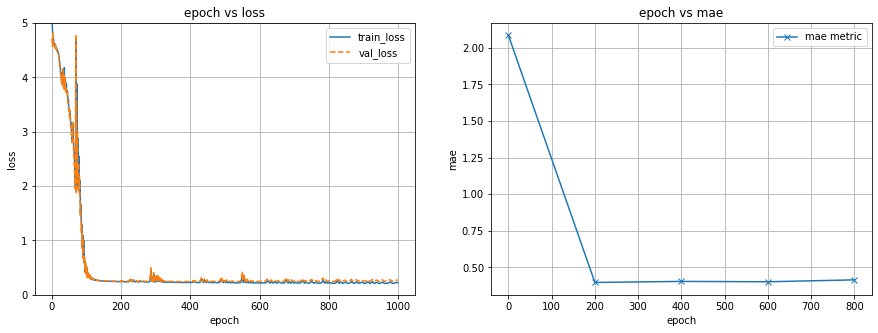

In [70]:
# 학습결과 차트로 보여주기
list_epoch,list_train_loss,list_val_loss,list_mae,list_mae_epoch = ep.getEpochList()
pltc = pltClass(list_epoch,list_train_loss,list_val_loss,list_mae_epoch,list_mae)
pltc.printFigure()